**Alzheimer's Stage Classification, using GRAD-CAM to explain predictions**
<br>
Author: Georgia Kopalidi<br>
This notebook is developed for a thesis project at Newcastle University

# Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 

from tensorflow.keras import Sequential, Input, layers, Model
from tensorflow.keras.layers import Dropout, MaxPool2D, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, InputLayer, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix, classification_report

import os
from distutils.dir_util import copy_tree, remove_tree

# Data Generators

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                    brightness_range=[0.8, 1.02],
                                    zoom_range=[.99, 1.01],
                                    horizontal_flip=True,
                                    fill_mode='constant')


test_datagen  = ImageDataGenerator(rescale = 1./255)

# Loading Dataset

In [3]:
base_dir = "/content/drive/MyDrive/MSc/Data/Alzheimer_s Dataset/"

# Training 
training_data_dir = base_dir + "train/"
test_data_dir = base_dir + "test/"

project_dir = "./dataset/"

os.mkdir(project_dir)
copy_tree(training_data_dir, project_dir)
copy_tree(test_data_dir, project_dir)

['./dataset/VeryMildDemented/26 (45).jpg',
 './dataset/VeryMildDemented/26 (54).jpg',
 './dataset/VeryMildDemented/26 (47).jpg',
 './dataset/VeryMildDemented/26 (49).jpg',
 './dataset/VeryMildDemented/26 (51).jpg',
 './dataset/VeryMildDemented/26 (50).jpg',
 './dataset/VeryMildDemented/26 (46).jpg',
 './dataset/VeryMildDemented/26 (52).jpg',
 './dataset/VeryMildDemented/26 (48).jpg',
 './dataset/VeryMildDemented/26 (55).jpg',
 './dataset/VeryMildDemented/26 (44).jpg',
 './dataset/VeryMildDemented/26 (53).jpg',
 './dataset/VeryMildDemented/27 (16).jpg',
 './dataset/VeryMildDemented/26 (57).jpg',
 './dataset/VeryMildDemented/27 (19).jpg',
 './dataset/VeryMildDemented/26 (63).jpg',
 './dataset/VeryMildDemented/26 (56).jpg',
 './dataset/VeryMildDemented/27 (10).jpg',
 './dataset/VeryMildDemented/26 (68).jpg',
 './dataset/VeryMildDemented/26 (67).jpg',
 './dataset/VeryMildDemented/27 (14).jpg',
 './dataset/VeryMildDemented/26 (61).jpg',
 './dataset/VeryMildDemented/27 (18).jpg',
 './dataset

In [4]:
# WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (176, 176)

In [5]:
all_data_gen = train_datagen.flow_from_directory(directory=project_dir, 
                                             target_size=DIM, 
                                             batch_size=6500,
                                             shuffle=False)

Found 6400 images belonging to 4 classes.


In [6]:
# test_data_gen = test_datagen.flow_from_directory(directory=test_data_dir, 
#                                               target_size=DIM, 
#                                               batch_size=6500, 
#                                               shuffle=False)

Found 1279 images belonging to 4 classes.


In [6]:
training_data, training_labels = all_data_gen.next()

In [7]:
print("Training Data shape: " , training_data.shape)
print("Training Labels shape: " , training_labels.shape)

Training Data shape:  (6400, 176, 176, 3)
Training Labels shape:  (6400, 4)


In [ ]:
test_data, test_labels = test_data_gen.next()

In [10]:
print("Testing Data shape: " , test_data.shape)
print("Testing Labels shape: " , test_labels.shape)

Testing Data shape:  (1279, 176, 176, 3)
Testing Labels shape:  (1279, 4)


In [9]:
all_data_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [12]:
test_data_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [10]:
sm = SMOTE(random_state=48)

training_data, training_labels = sm.fit_resample(training_data.reshape(-1, 176 * 176 * 3), training_labels)
training_data = training_data.reshape(-1, 176, 176, 3)

print(training_data.shape, training_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [11]:
training_data, valid_data, training_labels, valid_labels = train_test_split(training_data, training_labels, test_size = 0.2, random_state=48)
training_data, test_data, training_labels, test_labels = train_test_split(training_data, training_labels, test_size = 0.2, random_state=48)

In [12]:
print("Training Data shape: " , training_data.shape)
print("Training Labels shape: " , training_labels.shape)
print("Validation Data shape: " , valid_data.shape)
print("Validation Labels shape: " , valid_labels.shape)
print("Testing Data shape: " , test_data.shape)
print("Testing Labels shape: " , test_labels.shape)

Training Data shape:  (8192, 176, 176, 3)
Training Labels shape:  (8192, 4)
Validation Data shape:  (2560, 176, 176, 3)
Validation Labels shape:  (2560, 4)
Testing Data shape:  (2048, 176, 176, 3)
Testing Labels shape:  (2048, 4)


In [13]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation="relu", padding='same'),
        Conv2D(16, 3, activation="relu", padding='same'),
        MaxPool2D(),
        Conv2D(32, 3, activation="relu", padding='same'),
        Conv2D(32, 3, activation="relu", padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Conv2D(64, 3, activation="relu", padding='same'),
        Conv2D(64, 3, activation="relu", padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Conv2D(128, 3, activation="relu", padding='same'),
        Conv2D(128, 3, activation="relu", padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Dropout(0.2),
        Conv2D(256, 3, activation="relu", padding='same'),
        Conv2D(256, 3, activation="relu", padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(4, activation='softmax')        
    ],  name = "cnn_model")

In [14]:
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 88, 88, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 88, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 88, 88, 32)       128       
 ormalization)                                           

In [15]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [16]:
import keras

In [17]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [my_callback]
    
model.compile(optimizer="adam",
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

In [18]:
EPOCHS = 100

history = model.fit(training_data, training_labels, validation_data=(valid_data, valid_labels), callbacks=CALLBACKS, epochs=EPOCHS, verbose=1)

Epoch 1/100
256/256 [==============================] - 24s 41ms/step - loss: 1.4658 - acc: 0.3829 - auc: 0.6520 - val_loss: 5.9871 - val_acc: 0.2410 - val_auc: 0.5043
Epoch 2/100
256/256 [==============================] - 9s 36ms/step - loss: 0.9463 - acc: 0.5708 - auc: 0.8385 - val_loss: 3.3601 - val_acc: 0.2402 - val_auc: 0.5146
Epoch 3/100
256/256 [==============================] - 9s 36ms/step - loss: 0.7775 - acc: 0.6394 - auc: 0.8878 - val_loss: 1.1361 - val_acc: 0.5031 - val_auc: 0.7915
Epoch 4/100
256/256 [==============================] - 9s 36ms/step - loss: 0.7269 - acc: 0.6650 - auc: 0.9019 - val_loss: 0.9560 - val_acc: 0.5637 - val_auc: 0.8448
Epoch 5/100
256/256 [==============================] - 9s 36ms/step - loss: 0.6948 - acc: 0.6816 - auc: 0.9105 - val_loss: 2.2056 - val_acc: 0.4305 - val_auc: 0.7181
Epoch 6/100
256/256 [==============================] - 9s 36ms/step - loss: 0.6259 - acc: 0.7197 - auc: 0.9277 - val_loss: 1.2176 - val_acc: 0.5707 - val_auc: 0.8656
Epo

In [19]:
training_score = model.evaluate(training_data, training_labels)
validation_score = model.evaluate(valid_data, valid_labels)
testing_score = model.evaluate(test_data, test_labels)

print("Training Accuracy:" , (training_score[1] * 100))
print("Validation Accuracy: ", (validation_score[1] * 100))
print("Testing Accuracy: ", (testing_score[1] * 100))

64/64 [==============================] - 1s 12ms/step - loss: 0.2016 - acc: 0.9517 - auc: 0.9889
Training Accuracy: 99.74365234375
Validation Accuracy:  95.4296886920929
Testing Accuracy:  95.166015625


In [20]:
pred_labels = model.predict(test_data)

In [21]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       1.00      0.96      0.98       513
VeryMildDemented       1.00      1.00      1.00       511
    MildDemented       0.88      0.96      0.92       514
ModerateDemented       0.94      0.88      0.91       510

       micro avg       0.95      0.95      0.95      2048
       macro avg       0.95      0.95      0.95      2048
    weighted avg       0.95      0.95      0.95      2048
     samples avg       0.95      0.95      0.95      2048



In [22]:
import seaborn as sns

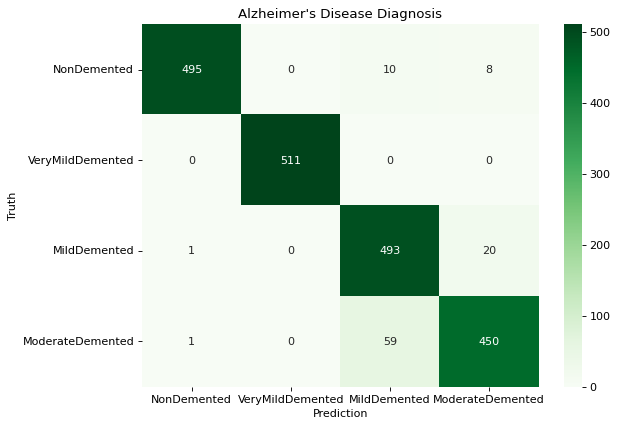

In [23]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [24]:
model_dir = "./alzheimer_cnn_95.16%"
model.save(model_dir, save_format='h5')

In [25]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()





In [40]:
img_path = "/content/dataset/VeryMildDemented/27 (50).jpg"
img = image.load_img(img_path, target_size=(176, 176))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=IMAGE_SIZE))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

In [41]:
classes = np.argmax(preds, axis = 1)
if classes == 0:
    print("Prediction: Mild Demented")
elif classes == 1: 
    print("Prediction: Moderated Demented")
elif classes == 2:
    print("Prediction: Non Demented")
elif classes == 3:
    print("Prediction: Very Mild Demented")
else: 
    print("There was an error. Please try again.")


Prediction: Very Mild Demented


In [38]:
all_data_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [ ]:
model.summary()

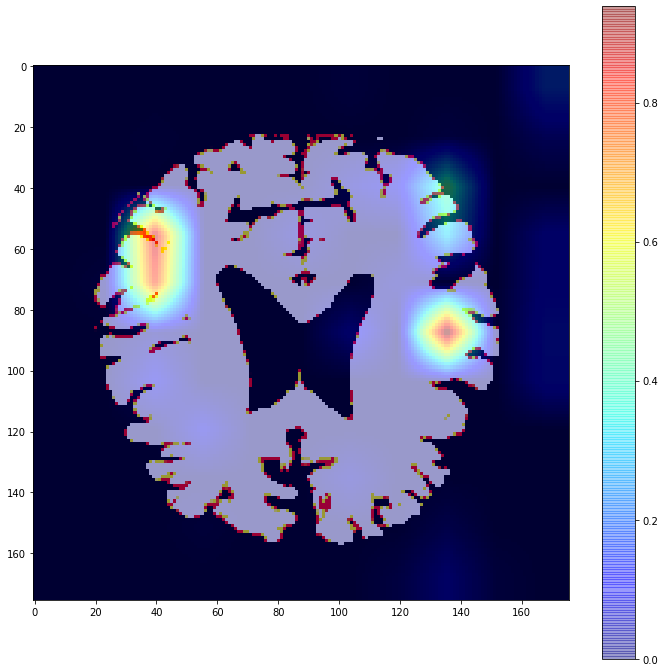

In [42]:
last_conv_layer_name = "conv2d_9"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.figure(figsize=(12,12))
plt.imshow(img_array[0])
plt.imshow(tf.image.resize(heatmap[...,np.newaxis], size=(img_array.shape[1], img_array.shape[2]))[:,:,0], alpha=0.4, cmap='jet')
plt.colorbar()
plt.show()